# Calculate how age wRC+ impacts wRC+
Stats: Age, wRC+

In [13]:
import utils
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
# load data
data = pd.read_csv('full_data.csv')

In [15]:
# get subsets of data containing just age and wRC+
X = pd.DataFrame({'Age': [], 'wRC+': []})
y = pd.DataFrame({'wRC+': []})

# iterate through data and connect ages and wRC+ to the following season's wRC+
for index, row in data.iterrows():
    next_year = data.loc[(data['PlayerId'] == row['PlayerId']) & (data['Season'] == row['Season'] + 1)]

    if next_year.size > 0:

        to_add_x = pd.DataFrame({'Age': [row['Age']], 'wRC+': [row['wRC+']]})
        X = pd.concat([X, to_add_x], ignore_index=True)

        to_add_y = pd.DataFrame({'wRC+': next_year['wRC+']})
        y = pd.concat([y, to_add_y], ignore_index=True)

# scale X
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

In [16]:
# display shape of data
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (1662, 2)
Shape of y: (1662, 1)


In [17]:
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

# convert train sets to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# convert test sets to tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [18]:
# set batch size
batch_size = 32

# create datasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# create dataloaders
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

for X, y in test_loader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X: torch.Size([32, 2])
Shape of y: torch.Size([32, 1]) torch.float32


In [19]:
# get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [20]:
# define model
model = utils.RegressionModel(X.shape[1]).to(device)
print(model)

RegressionModel(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=4, out_features=4, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=4, out_features=1, bias=True)
)


In [21]:
# define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)

Epoch 1
-------------------------------
Batch 1, Loss: 13217.0586
Batch 6, Loss: 10168.1299
Batch 11, Loss: 12410.7861
Batch 16, Loss: 10611.5938
Batch 21, Loss: 12589.4043
Batch 26, Loss: 11449.3623
Batch 31, Loss: 12031.7764
Batch 36, Loss: 13806.7051
Batch 41, Loss: 10425.5059
Average loss: 11607.019422743055
tensor([[-0.3318],
        [-0.3082],
        [-0.3291],
        [-0.3031],
        [-0.3246],
        [-0.3241],
        [-0.3064],
        [-0.3164],
        [-0.3031],
        [-0.3031],
        [-0.3064],
        [-0.3289],
        [-0.3031],
        [-0.0915],
        [-0.2943],
        [-0.2852],
        [-0.2235],
        [-0.3147],
        [-0.3031],
        [-0.3031],
        [-0.2037],
        [-0.3293],
        [-0.3031],
        [-0.2217],
        [-0.2925],
        [-0.3214],
        [-0.3175],
        [-0.2317],
        [-0.2832],
        [-0.2755],
        [-0.3246],
        [-0.3031]])
tensor([[-0.3186],
        [-0.3290],
        [-0.3159],
        [-0.3127],
 

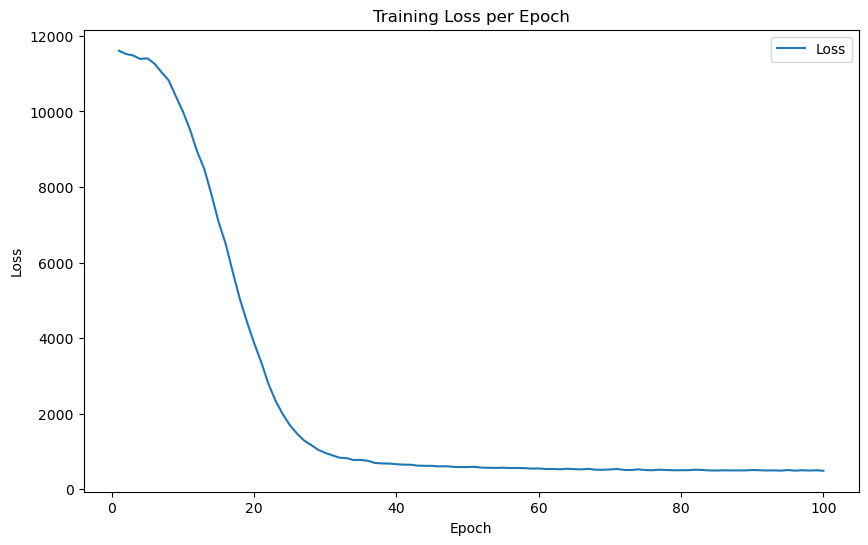

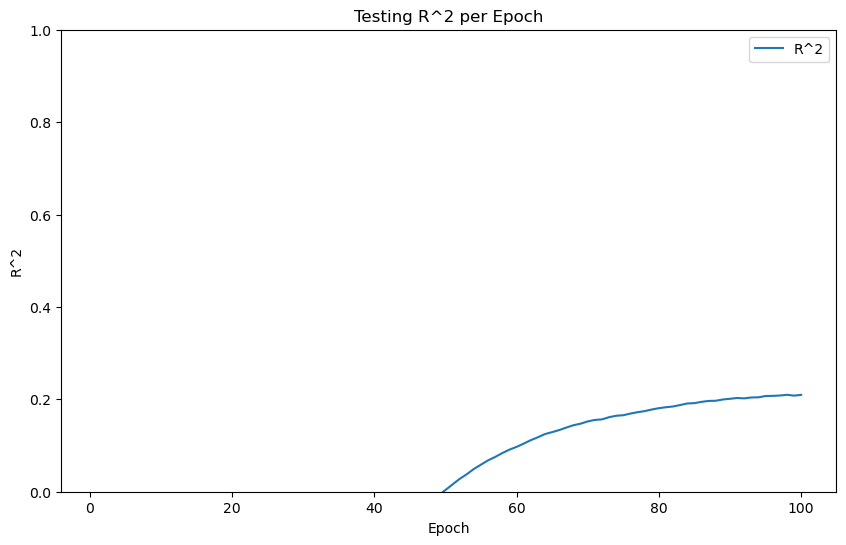

In [22]:
# run model
utils.run_model(100, train_loader, test_loader, model, loss_fn, optimizer, device)

In [23]:
# save model
torch.save(model.state_dict(), "models/model_1.pth")
print("Saved PyTorch Model State to 'model_1.pth' in 'models' folder")

Saved PyTorch Model State to 'model_1.pth' in 'models' folder
